In [1]:
import copy
import random
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import math
import torchvision.transforms as T
import numpy as np
import time
import socket
from IPython.display import clear_output

In [2]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim))
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr) #cambiar
        
    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        tensor = torch.Tensor(state)
        y_pred = self.model(tensor)
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

state_dim -> input red nuronal, depende del estado

action_dim -> 4 acciones: up, down, left y right

hidden_dim -> ajustar hiperparámetro

lr -> ajustar hiperparámetro

In [3]:
action_dim = 4
hidden_dim = 200
lr = 0.05

In [4]:
state_dim = 4

In [5]:
model = DQN(state_dim, action_dim, hidden_dim, lr)

### Prueba preliminar
Distancia a la pill más cercana en cada una de las direcciones.

In [6]:
episodes = 100
gamma = 0.7

In [7]:
class Game():
    def __init__(self, host="localhost", port=38514, numEpisodes = 100):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.episodes = numEpisodes
        try:
            self.sock.bind((host, port))
        except socket.error as err:
            print('Bind failed. Error Code : ' .format(err))
        
    def connect(self):
        self.sock.listen(1)
        self.conn, _ = self.sock.accept()
        self.conn.send(bytes(str(self.episodes) + "\n",'UTF-8'))
        
    def get_state(self):
        data = self.conn.recv(512)
        data = data.decode(encoding='UTF-8')
        lista=data.split(";")
        reward= int(lista[1])
        #print(data)
        if lista[0] == "gameOver":
            return None, reward
        next_state=list(map(int, lista[0].replace("[","").replace("]","").split(",")))
        return next_state,reward
    
    def send_action(self, action):
        self.conn.send(bytes(str(action) + "\n",'UTF-8'))

In [8]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(500, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [8]:
def q_learning(model, episodes = 100, gamma=0.7, epsilon=0.3, title = 'DQN'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game(numEpisodes = episodes)
    game.connect()
    final = []
    q_values = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
                
        # Reset state
        state, _ = game.get_state()
        
        total = 0
        
        while True:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            game.send_action(action)
            next_state, reward = game.get_state()    
           
            
            # Update total
            total += reward
            if type(q_values) != list:
                q_values = q_values.tolist()
            else:
                 q_values = model.predict(state).tolist()
            
            if next_state is None:
                q_values[action] = reward
                # Update network weights
                model.update(state, q_values)
                break
            
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            model.update(state, q_values)
            
            state = next_state
            
        
        final.append(total)
        plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        #torch.save(model, "model.mdl")
    return sum(final) / len(final)

In [9]:
def q_learning_old(model, episodes = 100, gamma=0.7, epsilon=0.3, title = 'DQN'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game(numEpisodes = episodes)
    game.connect()
    final = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
                
        # Reset state
        state = game.get_state()
        
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            q_values = model.predict(state) #Devuelve array con probabilidades de accion
            #action = torch.argmax(q_values).item() #Accion a realizar
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            next_state, reward, done = game.step(action) #Quizas reward requiera tratamiento, 
            
            #print("Action:" , action)
           #print("next_state", next_state)
            #print("reward", reward)
            #print("done", done)
            
            # Update total and memory
            total += reward
            q_values = q_values.tolist()
             
            if done:
                q_values[action] = reward
                # Update network weights
                model.update(state, q_values)
                break
                
            # Update network weights using the last step only
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            model.update(state, q_values)
            
            state = game.get_state()
            #state = next_state
        
        final.append(total)
        #plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        #if total == 500:
            #torch.save(model, "model.mdl")
            #return final
    return final
    
    

In [12]:
q_learning(model, episodes=30, epsilon=1)

ConnectionResetError: [WinError 10054] Se ha forzado la interrupción de una conexión existente por el host remoto

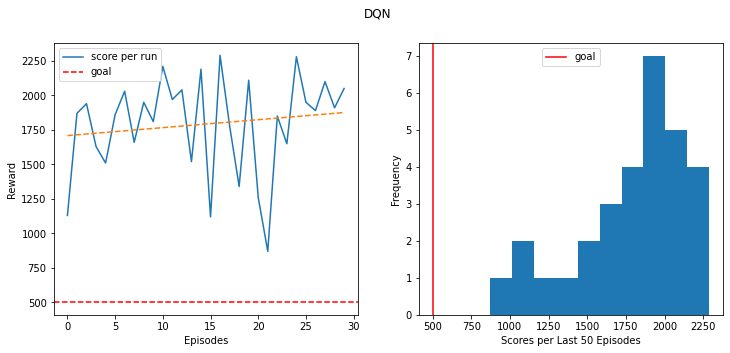

1792.3333333333333

In [39]:
q_learning(model, episodes=30, epsilon=0.1)

In [40]:
class DQN_replay(DQN):
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory) >= size:
            batch = random.sample(memory,size)
            
            batch_t = list(map(list, zip(*batch))) #Transpose batch list

            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

In [41]:
def q_learning_replay(model, episodes=100, gamma=0.7, epsilon=0.3, replay_size=20, title='DQN Replay'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game(numEpisodes = episodes)
    game.connect()
    final = []
    q_values = []
    memory = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
        intersecciones = 1     
        # Reset state
        state, _ = game.get_state()
        
        total = 0
        
        while True:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            game.send_action(action)
            next_state, reward = game.get_state()
            intersecciones += 1
            # Update total
            total += reward
            if type(q_values) != list:
                q_values = q_values.tolist()
            else:
                 q_values = model.predict(state).tolist()

            if next_state is None:
                break

            memory.append((state, action, next_state, reward, next_state is None))
            
            model.replay(memory, replay_size, gamma)
            
            state = next_state
        
        final.append(total)
        plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        torch.save(model, "model.mdl")
    return sum(final)/len(final)

In [42]:
model = DQN_replay(state_dim, action_dim, hidden_dim, lr)

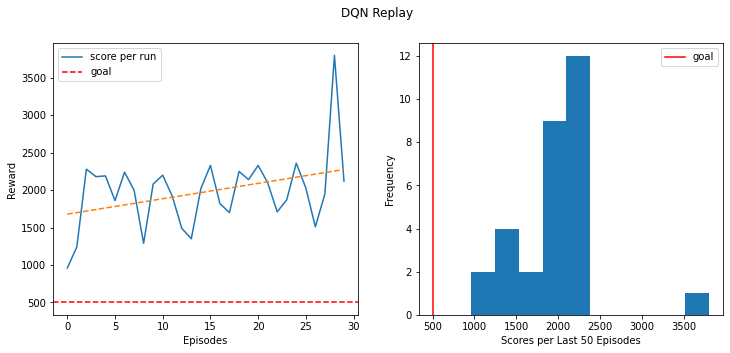

1977.3333333333333

In [49]:
q_learning_replay(model, episodes=30, epsilon=0.1, replay_size=340)

Hiperparámetros a ajustar:
* Learning rate
* Hidden dimension
* Number of episodes
* Epsilon
* Gamma

Específica del replay DQN
* Replay size

In [44]:
def adjust_parameters(episodes=(100, 1000, 10), hidden_layers=(100, 1000, 10), epsilon=(0.01, 0.1, 10), gamma=(0.5, 1, 10), lr=(0.01, 0.1, 5)):
    means = []

    episodes_list = np.linspace(episodes[0], episodes[1], episodes[2]).astype(int).tolist()
    hidden_layers_list = np.linspace(hidden_layers[0], hidden_layers[1], hidden_layers[2]).astype(int).tolist()
    epsilon_list = np.linspace(epsilon[0], epsilon[1], epsilon[2]).tolist()
    gamma_list = np.linspace(gamma[0], gamma[1], gamma[2]).tolist()
    lr_list = np.linspace(lr[0], lr[1], lr[2]).tolist()

    for episode in episodes_list:
        for hidden_layer in hidden_layers_list:
            for eps in epsilon_list:
                for gam in gamma_list:
                    for l in lr_list:
                        model = DQN(4, 4, hidden_layer, l)
                        mean = q_learning(model, episodes=episode, gamma=gam, epsilon=eps)
                        print(mean)
                        means.append((mean, episode, hidden_layer, eps, gam, l))

    return means



In [45]:
#adjust_parameters(episodes=(100, 1000, 2), hidden_layers=(100, 1000, 2), epsilon=(0.01, 0.1, 2), gamma=(0.5, 1, 2), lr=(0.01, 0.1, 2))

Nuevo Game con estado ampliado

In [3]:
class Game_Ampliado():
    def __init__(self, host="localhost", port=38514, numEpisodes = 100):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.episodes = numEpisodes
        try:
            self.sock.bind((host, port))
        except socket.error as err:
            print('Bind failed. Error Code : ' .format(err))
        
    def connect(self):
        self.sock.listen(1)
        self.conn, _ = self.sock.accept()
        self.conn.send(bytes(str(self.episodes) + "\n",'UTF-8'))
        
    def get_state(self):
        data = self.conn.recv(512)
        data = data.decode(encoding='UTF-8')
        lista=data.split(";")
        reward= int(lista[1])
        #print(data)
        if lista[0] == "gameOver":
            return None, reward
            
        lista_estado=lista[0].split("/")
        
        list_dist_pills=list(map(int, lista_estado[0].replace("[","").replace("]","").split(",")))
        list_dist_power_pills=list(map(int, lista_estado[1].replace("[","").replace("]","").split(",")))
        num_pills=int (lista_estado[2])
        num_power_pills= int (lista_estado[3])
        current_time = int(lista_estado[4])
        list_dist_ghosts=list(map(int, lista_estado[5].replace("[","").replace("]","").split(",")))
        list_dir_ghosts=list(map(int, lista_estado[6].replace("[","").replace("]","").split(",")))
        list_edible_ghosts=list(map(int, lista_estado[7].replace("[","").replace("]","").split(",")))
        lair_time= int (lista_estado[8])
        
        next_state=list_dist_pills+ list_dist_power_pills + list_dist_ghosts + list_dir_ghosts + list_edible_ghosts + [num_pills, num_power_pills, current_time, lair_time]
        print(next_state)
        return next_state,reward
    
    def send_action(self, action):
        self.conn.send(bytes(str(action) + "\n",'UTF-8'))

In [4]:
def q_learning_ampliado(model, episodes = 100, gamma=0.7, epsilon=0.3, title = 'DQN'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game_Ampliado(numEpisodes = episodes)
    game.connect()
    final = []
    q_values = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
                
        # Reset state
        state, _ = game.get_state()
        
        total = 0
        
        while True:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            game.send_action(action)
            next_state, reward = game.get_state()    
           
            
            # Update total
            total += reward
            if type(q_values) != list:
                q_values = q_values.tolist()
            else:
                 q_values = model.predict(state).tolist()
            
            if next_state is None:
                q_values[action] = reward
                # Update network weights
                model.update(state, q_values)
                break
            
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            model.update(state, q_values)
            
            state = next_state
            
        
        final.append(total)
        #plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        #torch.save(model, "model.mdl")
    return sum(final) / len(final)

In [5]:
action_dim = 4
hidden_dim = 200
lr = 0.05
state_dim = 24
model = DQN(state_dim, action_dim, hidden_dim, lr)
episodes = 100
gamma = 0.7
q_learning_ampliado(model, episodes=30)

[4, 250, 250, 4, 40, 250, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 218, 4, 8, 50]
[4, 250, 250, 4, 28, 250, 250, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 215, 4, 20, 50]
[4, 4, 250, 250, 92, 92, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 203, 3, 72, 50]
[4, 4, 250, 250, 80, 80, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 200, 3, 84, 50]
[4, 4, 250, 4, 68, 68, 250, 68, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 197, 3, 96, 50]
[4, 4, 250, 250, 44, 44, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 3, 120, 50]
[12, 12, 28, 250, 68, 68, 68, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 3, 144, 50]
[250, 4, 250, 4, 250, 80, 250, 56, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 190, 3, 156, 50]
[250, 4, 250, 4, 250, 64, 250, 52, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 183, 3, 184, 50]
[250, 4, 4, 250, 250, 52, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 180, 3, 196, 50]
[4, 4, 25

[250, 68, 250, 81, 250, 148, 250, 161, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3276, 50]
[250, 56, 56, 250, 250, 136, 136, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3288, 50]
[44, 44, 250, 250, 124, 124, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3300, 50]
[250, 80, 250, 69, 250, 160, 250, 149, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3360, 50]
[250, 68, 68, 250, 250, 148, 148, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3372, 50]
[250, 56, 56, 250, 250, 136, 136, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3384, 50]
[44, 44, 250, 250, 124, 124, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3396, 50]
[250, 80, 250, 69, 250, 160, 250, 149, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3456, 50]
[250, 68, 68, 250, 250, 148, 148, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 55, 1, 3468, 50]
[250, 56, 56, 250, 250, 136, 136, 250, 250, 250, 250, 250, 4, 4,

[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1158, 50]
[16, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1170, 50]
[250, 250, 36, 36, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1198, 50]
[250, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1226, 50]
[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1238, 50]
[16, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1250, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1262, 50]
[250, 16, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1314, 50]
[250, 250, 36, 36, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1342, 50]
[250, 24, 24, 48, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50,

[4, 250, 4, 4, 28, 250, 28, 36, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 508, 50]
[4, 250, 250, 4, 40, 250, 250, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 183, 3, 520, 50]
[250, 250, 4, 4, 250, 250, 52, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 180, 3, 532, 50]
[250, 250, 4, 4, 250, 250, 64, 109, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 177, 3, 544, 50]
[4, 250, 250, 4, 76, 250, 250, 97, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 174, 3, 556, 50]
[16, 250, 16, 16, 85, 250, 85, 85, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 172, 3, 568, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 172, 3, 580, 50]
[250, 16, 16, 16, 250, 88, 85, 85, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 172, 3, 632, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 172, 3, 644, 50]
[250, 16, 16, 16, 250, 88, 85, 85, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 172, 3, 696, 50]
[2

[4, 250, 250, 4, 40, 250, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 85, 1, 2330, 50]
[4, 250, 250, 4, 28, 250, 250, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 82, 1, 2342, 50]
[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 0, 2394, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 67, 0, 2406, 50]
[250, 16, 250, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 62, 0, 2430, 50]
[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 62, 0, 2442, 50]
[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 62, 0, 2478, 50]
[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 62, 0, 2490, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 62, 0, 2542, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50,

[16, 4, 4, 250, 85, 88, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 196, 3, 230, 50]
[250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 196, 3, 282, 50]
[16, 4, 4, 250, 85, 88, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 196, 3, 294, 50]
[250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 196, 3, 346, 50]
[16, 4, 4, 250, 85, 88, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 196, 3, 358, 50]
[4, 4, 250, 250, 76, 76, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 196, 3, 370, 50]
[250, 4, 250, 4, 250, 40, 250, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 181, 3, 430, 50]
[4, 4, 4, 250, 28, 28, 28, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 178, 3, 442, 50]
[250, 250, 4, 4, 250, 250, 100, 100, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 166, 2, 494, 50]
[250, 4, 4, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 162, 2, 510, 50]
[4, 250

[250, 68, 250, 68, 250, 136, 250, 136, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2120, 50]
[250, 93, 80, 250, 250, 161, 148, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2132, 50]
[250, 76, 76, 250, 250, 133, 133, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2160, 50]
[69, 69, 250, 104, 137, 137, 250, 161, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2188, 50]
[250, 57, 57, 250, 250, 125, 125, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2200, 50]
[250, 69, 69, 104, 250, 137, 137, 161, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2252, 50]
[250, 250, 76, 76, 250, 250, 133, 133, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2280, 50]
[250, 93, 250, 80, 250, 161, 250, 148, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2308, 50]
[81, 81, 250, 250, 149, 149, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 48, 1, 2320, 50]
[69, 69, 69, 250, 137, 137, 137, 250, 250, 250, 250, 250, 4, 4, 

[250, 104, 80, 80, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 5, 0, 3986, 50]
[4, 250, 4, 250, 32, 250, 57, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 219, 4, 20, 50]
[250, 4, 250, 4, 250, 16, 250, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 215, 4, 36, 50]
[250, 4, 4, 4, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 203, 3, 88, 50]
[250, 20, 16, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 3, 100, 50]
[250, 4, 4, 4, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 3, 152, 50]
[250, 20, 16, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 3, 164, 50]
[250, 4, 4, 4, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 3, 216, 50]
[250, 20, 16, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 3, 228, 50]
[250, 4, 4, 4, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 3, 280, 50]
[250, 

[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3221, 50]
[16, 69, 16, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3233, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3285, 50]
[16, 250, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3297, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3309, 50]
[250, 250, 16, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3321, 50]
[250, 250, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3333, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3345, 50]
[16, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 47, 0, 3357, 50]
[250, 250, 16, 32, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 

[250, 250, 4, 4, 250, 250, 92, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 132, 1, 1087, 50]
[250, 4, 250, 4, 250, 109, 250, 64, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 125, 1, 1115, 50]
[4, 4, 250, 250, 76, 97, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 122, 1, 1127, 50]
[16, 16, 16, 250, 85, 85, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1, 1139, 50]
[250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1, 1151, 50]
[250, 16, 16, 16, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1, 1203, 50]
[250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1, 1215, 50]
[250, 16, 16, 16, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1, 1267, 50]
[4, 250, 250, 4, 76, 250, 250, 76, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1, 1279, 50]
[250, 250, 4, 4, 250, 250, 64, 64, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 1,

[24, 24, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 2913, 50]
[4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 2949, 50]
[16, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 2961, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 3013, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 3025, 50]
[29, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 3037, 50]
[52, 250, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 3073, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 3097, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 0, 3109, 50]
[28, 250, 250, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4

[4, 4, 250, 250, 88, 88, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 113, 1, 943, 50]
[4, 4, 250, 250, 76, 76, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 110, 1, 955, 50]
[4, 4, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 1, 991, 50]
[4, 4, 250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 98, 1, 1003, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 86, 0, 1055, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 83, 0, 1067, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 80, 0, 1079, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 77, 0, 1091, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 76, 0, 1103, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 73, 0

[250, 68, 68, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2823, 50]
[250, 250, 52, 52, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2839, 50]
[250, 40, 40, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2851, 50]
[250, 16, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2875, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2887, 50]
[250, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2899, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2911, 50]
[16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2923, 50]
[250, 28, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 18, 0, 2935, 50]
[250, 28, 250, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4,

[250, 53, 16, 16, 250, 85, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 572, 50]
[250, 250, 32, 32, 250, 250, 92, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 600, 50]
[250, 16, 250, 4, 250, 109, 250, 64, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 628, 50]
[4, 4, 250, 250, 76, 97, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 640, 50]
[16, 53, 16, 250, 85, 85, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 652, 50]
[250, 250, 32, 32, 250, 250, 92, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 680, 50]
[250, 44, 48, 44, 250, 93, 93, 104, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 692, 50]
[250, 48, 48, 250, 250, 105, 109, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 704, 50]
[250, 250, 24, 24, 250, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 728, 50]
[250, 4, 4, 250, 250, 96, 96, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 116,

[16, 250, 250, 16, 153, 250, 250, 153, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2568, 50]
[4, 250, 250, 4, 165, 250, 250, 176, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2580, 50]
[40, 250, 250, 52, 140, 250, 250, 140, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2616, 50]
[52, 250, 250, 52, 128, 250, 250, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2628, 50]
[16, 16, 250, 250, 92, 92, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2680, 50]
[250, 28, 28, 250, 250, 128, 104, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2692, 50]
[16, 16, 250, 250, 116, 116, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2704, 50]
[250, 16, 16, 250, 250, 165, 128, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2716, 50]
[250, 4, 4, 250, 250, 153, 140, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 65, 1, 2728, 50]
[16, 52, 250, 250, 141, 141, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4,

[250, 48, 250, 40, 250, 140, 250, 164, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 627, 50]
[40, 40, 250, 250, 128, 128, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 639, 50]
[16, 250, 250, 16, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 691, 50]
[250, 250, 16, 16, 250, 250, 104, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 703, 50]
[250, 40, 250, 40, 250, 128, 250, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 727, 50]
[16, 250, 250, 16, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 779, 50]
[250, 250, 16, 16, 250, 250, 104, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 791, 50]
[250, 40, 250, 40, 250, 128, 250, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 815, 50]
[16, 250, 250, 16, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 144, 2, 867, 50]
[4, 250, 250, 4, 80, 250, 250, 80, 250, 250, 250, 250, 4, 4, 4, 4, 50,

[77, 250, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2439, 50]
[65, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2451, 50]
[77, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2476, 50]
[250, 56, 250, 56, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2492, 50]
[68, 92, 68, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2504, 50]
[250, 56, 56, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2556, 50]
[68, 92, 68, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2568, 50]
[80, 104, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2580, 50]
[250, 92, 92, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2592, 50]
[250, 100, 100, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4

[16, 16, 16, 250, 85, 85, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 330, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 382, 50]
[16, 250, 16, 16, 85, 250, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 394, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 446, 50]
[16, 250, 16, 16, 85, 250, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 458, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 510, 50]
[16, 250, 16, 16, 85, 250, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 522, 50]
[250, 250, 32, 32, 250, 250, 92, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 550, 50]
[250, 24, 24, 44, 250, 93, 93, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 562, 50]
[250, 36, 36, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 574, 

[250, 4, 250, 4, 250, 76, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 215, 4, 20, 50]
[4, 4, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 206, 4, 56, 50]
[4, 4, 250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 203, 4, 68, 50]
[4, 250, 250, 4, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 3, 120, 50]
[250, 250, 4, 4, 250, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 188, 3, 132, 50]
[4, 250, 250, 4, 84, 250, 250, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 185, 3, 144, 50]
[250, 250, 4, 4, 250, 250, 72, 72, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 182, 3, 156, 50]
[250, 250, 4, 4, 250, 250, 60, 60, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 181, 3, 168, 50]
[250, 40, 250, 4, 250, 96, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 177, 3, 204, 50]
[4, 4, 250, 250, 76, 108, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 177, 3, 240, 50]
[

[80, 100, 250, 80, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3625, 50]
[250, 250, 68, 68, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3637, 50]
[250, 100, 80, 80, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3689, 50]
[250, 250, 68, 68, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3701, 50]
[250, 100, 80, 80, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3753, 50]
[250, 72, 72, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3781, 50]
[250, 100, 250, 100, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3809, 50]
[250, 100, 100, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3821, 50]
[92, 92, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 0, 3833, 50]
[80, 80, 80, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4,

[250, 4, 4, 250, 250, 108, 108, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1463, 50]
[250, 16, 40, 16, 250, 96, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1475, 50]
[250, 250, 40, 28, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1487, 50]
[250, 24, 24, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1511, 50]
[250, 250, 4, 4, 250, 250, 60, 60, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 127, 2, 1535, 50]
[4, 250, 4, 250, 84, 250, 36, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 121, 2, 1559, 50]
[25, 16, 250, 16, 73, 48, 250, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 119, 2, 1571, 50]
[16, 16, 250, 250, 120, 72, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 119, 2, 1595, 50]
[16, 16, 40, 250, 96, 96, 96, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 119, 2, 1619, 50]
[250, 250, 52, 28, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 5

[76, 250, 64, 64, 96, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3117, 50]
[250, 76, 250, 76, 250, 108, 250, 108, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3129, 50]
[250, 104, 250, 104, 250, 136, 250, 136, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3157, 50]
[250, 104, 104, 250, 250, 161, 148, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3169, 50]
[250, 76, 76, 250, 250, 133, 133, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3197, 50]
[250, 64, 64, 64, 250, 121, 121, 121, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3209, 50]
[88, 250, 40, 250, 121, 250, 97, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3233, 50]
[89, 52, 250, 250, 109, 109, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3245, 50]
[77, 250, 64, 250, 134, 250, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 45, 1, 3270, 50]
[250, 80, 250, 80, 250, 100, 250, 100, 250, 250, 250, 250, 4, 4, 4,

[4, 4, 250, 250, 32, 32, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 107, 1, 790, 50]
[250, 4, 250, 4, 250, 16, 250, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 103, 1, 806, 50]
[250, 4, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 91, 0, 858, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 84, 0, 886, 50]
[250, 4, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 77, 0, 914, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 74, 0, 926, 50]
[250, 250, 32, 32, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 68, 0, 954, 50]
[4, 4, 250, 60, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 68, 0, 982, 50]
[250, 250, 16, 56, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 68, 0, 994, 50]
[250, 4, 4, 60, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 68, 0, 1

[250, 52, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2680, 50]
[250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2692, 50]
[250, 16, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2716, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2728, 50]
[250, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2740, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2792, 50]
[250, 28, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2816, 50]
[16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2828, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2840, 50]
[41, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4,

[28, 250, 250, 28, 149, 250, 250, 160, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2122, 50]
[250, 250, 16, 16, 250, 250, 148, 148, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2134, 50]
[250, 250, 4, 4, 250, 250, 136, 136, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2146, 50]
[16, 250, 250, 16, 124, 250, 250, 124, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2158, 50]
[28, 250, 4, 4, 112, 250, 112, 112, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2170, 50]
[250, 250, 16, 32, 250, 250, 100, 100, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2182, 50]
[250, 250, 16, 16, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2198, 50]
[250, 4, 4, 250, 250, 72, 72, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 75, 1, 2210, 50]
[250, 16, 16, 16, 250, 48, 48, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 2234, 50]
[250, 4, 4, 250, 250, 36, 36, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 

[250, 4, 250, 12, 250, 60, 250, 72, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 122, 2, 869, 50]
[16, 16, 250, 250, 48, 48, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 2, 881, 50]
[250, 4, 250, 28, 250, 60, 250, 60, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 2, 893, 50]
[4, 250, 4, 250, 84, 250, 36, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 114, 2, 917, 50]
[4, 4, 250, 4, 73, 48, 250, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 111, 2, 929, 50]
[4, 250, 250, 4, 120, 250, 250, 72, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 105, 2, 953, 50]
[16, 250, 28, 16, 96, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 105, 2, 977, 50]
[12, 250, 24, 12, 96, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 105, 2, 1013, 50]
[4, 250, 4, 250, 120, 250, 72, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 104, 2, 1037, 50]
[250, 4, 4, 4, 250, 48, 48, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 98, 2, 1061, 50

[250, 65, 250, 65, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3651, 50]
[88, 250, 250, 88, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3703, 50]
[76, 250, 250, 76, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3715, 50]
[250, 88, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3751, 50]
[52, 76, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3763, 50]
[250, 77, 64, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3775, 50]
[65, 65, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3787, 50]
[88, 250, 250, 88, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3839, 50]
[76, 250, 250, 76, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 7, 0, 3851, 50]
[250, 88, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50

[4, 4, 250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 117, 2, 1528, 50]
[4, 250, 250, 4, 97, 250, 250, 97, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 105, 1, 1580, 50]
[250, 250, 4, 4, 250, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 102, 1, 1592, 50]
[4, 250, 250, 4, 84, 250, 250, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 99, 1, 1604, 50]
[250, 250, 4, 4, 250, 250, 72, 72, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 96, 1, 1616, 50]
[250, 250, 4, 4, 250, 250, 60, 60, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 95, 1, 1628, 50]
[4, 250, 250, 4, 48, 250, 250, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 92, 1, 1640, 50]
[250, 250, 16, 16, 250, 250, 36, 36, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 90, 1, 1652, 50]
[250, 16, 250, 4, 250, 60, 250, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 90, 1, 1676, 50]
[4, 4, 250, 250, 40, 96, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 90, 1, 1688

[250, 40, 28, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3418, 50]
[250, 52, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3442, 50]
[40, 250, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3494, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3506, 50]
[250, 52, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3530, 50]
[40, 250, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3582, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3594, 50]
[250, 52, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3618, 50]
[40, 250, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 41, 0, 3670, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4,

[250, 28, 28, 250, 250, 52, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 19, 1, 3117, 50]
[16, 16, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 19, 1, 3129, 50]
[4, 4, 4, 250, 28, 28, 28, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 19, 1, 3141, 50]
[250, 4, 4, 250, 250, 16, 16, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 16, 1, 3153, 50]
[250, 16, 16, 56, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 5, 0, 3205, 50]
[250, 250, 44, 52, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 5, 0, 3233, 50]
[250, 40, 250, 72, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 5, 0, 3261, 50]
[250, 250, 52, 81, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 5, 0, 3273, 50]
[64, 250, 250, 69, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 5, 0, 3285, 50]
[57, 250, 57, 57, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50,

[250, 28, 250, 32, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2807, 50]
[16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2819, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2831, 50]
[29, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2843, 50]
[77, 250, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2867, 50]
[65, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2879, 50]
[250, 68, 250, 68, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2895, 50]
[250, 80, 80, 104, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2947, 50]
[250, 250, 76, 76, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 25, 0, 2975, 50]
[250, 64, 64, 64, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 

[4, 4, 250, 250, 48, 72, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 158, 3, 523, 50]
[250, 4, 4, 250, 250, 72, 60, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 155, 3, 535, 50]
[250, 4, 250, 4, 250, 76, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 146, 3, 571, 50]
[4, 250, 250, 4, 28, 250, 250, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 143, 3, 583, 50]
[16, 16, 250, 250, 92, 92, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 132, 2, 635, 50]
[250, 4, 4, 250, 250, 96, 96, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 132, 2, 647, 50]
[4, 4, 250, 250, 84, 84, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 132, 2, 659, 50]
[250, 12, 12, 250, 250, 72, 72, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 132, 2, 671, 50]
[250, 4, 250, 16, 250, 76, 250, 108, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 132, 2, 707, 50]
[4, 4, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 123, 2, 743

[250, 16, 16, 250, 250, 52, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 119, 50]
[4, 4, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 131, 50]
[250, 16, 250, 4, 250, 76, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 191, 50]
[250, 4, 4, 250, 250, 64, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 203, 50]
[250, 16, 16, 250, 250, 52, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 215, 50]
[4, 4, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 227, 50]
[250, 16, 250, 4, 250, 76, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 287, 50]
[250, 4, 4, 250, 250, 64, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 299, 50]
[250, 16, 16, 250, 250, 52, 52, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 311, 50]
[4, 4, 250, 250, 40, 40, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 191, 4, 3

[250, 250, 4, 4, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 103, 2, 2719, 50]
[250, 40, 40, 250, 250, 72, 72, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2731, 50]
[250, 16, 16, 16, 250, 48, 48, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2755, 50]
[52, 250, 52, 250, 84, 250, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2791, 50]
[250, 28, 28, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2815, 50]
[250, 24, 24, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2827, 50]
[40, 40, 250, 250, 84, 84, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2851, 50]
[41, 4, 4, 250, 73, 48, 48, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2887, 50]
[29, 16, 16, 250, 73, 48, 48, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 101, 2, 2912, 50]
[52, 250, 52, 250, 84, 250, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50

[250, 250, 36, 36, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 122, 2, 1284, 50]
[250, 24, 24, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 122, 2, 1308, 50]
[250, 250, 4, 4, 250, 250, 60, 60, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 121, 2, 1332, 50]
[250, 4, 250, 4, 250, 72, 250, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 118, 2, 1344, 50]
[250, 4, 4, 250, 250, 72, 60, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 115, 2, 1356, 50]
[250, 4, 4, 250, 250, 60, 60, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 114, 2, 1368, 50]
[250, 4, 250, 4, 250, 40, 250, 76, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 105, 2, 1404, 50]
[4, 250, 250, 4, 40, 250, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 96, 2, 1440, 50]
[4, 250, 250, 4, 28, 250, 250, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 93, 2, 1452, 50]
[4, 4, 250, 250, 97, 97, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 81, 1,

[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 3998, 50]
[250, 250, 4, 4, 250, 250, 56, 80, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 214, 4, 23, 50]
[250, 4, 250, 4, 250, 52, 250, 64, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 207, 4, 51, 50]
[250, 250, 4, 4, 250, 250, 52, 52, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 204, 4, 63, 50]
[4, 250, 250, 4, 40, 250, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 201, 4, 75, 50]
[4, 250, 4, 4, 28, 250, 28, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 198, 4, 87, 50]
[250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 186, 3, 139, 50]
[16, 4, 4, 250, 85, 88, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 184, 3, 151, 50]
[250, 4, 4, 250, 250, 92, 92, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 177, 3, 179, 50]
[250, 16, 250, 16, 250, 64, 250, 109, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 171, 3, 207, 50]
[250,

[60, 61, 60, 250, 121, 121, 121, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 58, 1, 2752, 50]
[37, 250, 53, 250, 121, 250, 97, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 58, 1, 2776, 50]
[25, 25, 250, 250, 109, 109, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 58, 1, 2788, 50]
[4, 250, 4, 250, 134, 250, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 57, 1, 2813, 50]
[250, 20, 250, 20, 250, 100, 250, 100, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 54, 1, 2829, 50]
[32, 64, 32, 250, 112, 136, 112, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 54, 1, 2841, 50]
[250, 20, 20, 250, 250, 100, 100, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 54, 1, 2893, 50]
[32, 64, 32, 250, 112, 136, 112, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 54, 1, 2905, 50]
[250, 20, 20, 250, 250, 100, 100, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 54, 1, 2957, 50]
[250, 250, 4, 4, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 

[4, 250, 250, 4, 76, 250, 250, 76, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 162, 3, 452, 50]
[250, 250, 16, 28, 250, 250, 64, 64, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 162, 3, 464, 50]
[250, 250, 16, 16, 250, 250, 52, 52, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 162, 3, 476, 50]
[4, 250, 250, 4, 40, 250, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 162, 3, 488, 50]
[250, 28, 250, 52, 250, 97, 250, 76, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 148, 3, 548, 50]
[16, 16, 16, 250, 85, 85, 85, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 148, 3, 560, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 148, 3, 612, 50]
[16, 250, 16, 56, 85, 250, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 148, 3, 624, 50]
[250, 250, 4, 4, 250, 250, 73, 73, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 148, 3, 676, 50]
[16, 250, 16, 56, 85, 250, 85, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 148, 3, 688

[80, 250, 80, 80, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3201, 50]
[250, 72, 72, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3229, 50]
[250, 100, 250, 100, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3257, 50]
[250, 104, 104, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3269, 50]
[116, 116, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3281, 50]
[250, 112, 250, 92, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3341, 50]
[250, 100, 100, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3353, 50]
[250, 104, 104, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3365, 50]
[116, 116, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 15, 0, 3377, 50]
[250, 112, 250, 92, 250, 250, 250, 250, 250, 250, 25

[16, 16, 250, 250, 124, 148, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1466, 50]
[250, 4, 4, 250, 250, 136, 136, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1478, 50]
[250, 77, 16, 250, 250, 161, 148, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1490, 50]
[28, 65, 250, 250, 149, 149, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1502, 50]
[40, 53, 40, 250, 137, 137, 137, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1514, 50]
[250, 41, 41, 250, 250, 125, 125, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1526, 50]
[250, 53, 40, 40, 250, 137, 137, 161, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1578, 50]
[250, 250, 44, 44, 250, 250, 133, 133, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1606, 50]
[250, 77, 250, 16, 250, 161, 250, 148, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 70, 1, 1634, 50]
[250, 250, 4, 4, 250, 250, 136, 136, 250, 250, 250, 250, 4, 4, 4, 4,

[250, 250, 4, 4, 250, 250, 36, 36, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 168, 3, 290, 50]
[4, 250, 250, 4, 24, 250, 250, 24, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 165, 3, 302, 50]
[4, 4, 250, 250, 128, 128, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 153, 2, 354, 50]
[16, 40, 250, 250, 140, 164, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 151, 2, 366, 50]
[4, 4, 250, 250, 140, 140, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 151, 2, 402, 50]
[4, 4, 250, 250, 128, 128, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 151, 2, 414, 50]
[4, 250, 250, 4, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 151, 2, 466, 50]
[250, 250, 4, 4, 250, 250, 104, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 151, 2, 478, 50]
[4, 250, 250, 4, 116, 250, 250, 116, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 151, 2, 490, 50]
[250, 250, 4, 4, 250, 250, 128, 140, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 1

[250, 250, 4, 4, 250, 250, 64, 64, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 52, 1, 3274, 50]
[250, 250, 16, 16, 250, 250, 52, 52, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 52, 1, 3286, 50]
[4, 250, 250, 4, 40, 250, 250, 40, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 52, 1, 3298, 50]
[4, 250, 4, 4, 28, 250, 28, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 49, 1, 3310, 50]
[250, 250, 4, 4, 250, 250, 16, 16, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 46, 1, 3322, 50]
[250, 4, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 3374, 50]
[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 3386, 50]
[250, 4, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 3438, 50]
[250, 40, 40, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 29, 0, 3466, 50]
[250, 16, 250, 40, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 29, 0, 3

[250, 48, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 43, 0, 2043, 50]
[250, 250, 36, 36, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 43, 0, 2055, 50]
[250, 24, 24, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 43, 0, 2079, 50]
[250, 24, 24, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 43, 0, 2091, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 42, 0, 2115, 50]
[250, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 40, 0, 2127, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 40, 0, 2139, 50]
[250, 52, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2163, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 35, 0, 2175, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 

[4, 4, 250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 165, 3, 303, 50]
[4, 250, 250, 4, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 153, 2, 355, 50]
[250, 250, 4, 4, 250, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 150, 2, 367, 50]
[250, 28, 250, 16, 250, 120, 250, 88, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 145, 2, 391, 50]
[4, 250, 250, 4, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 145, 2, 443, 50]
[250, 250, 4, 4, 250, 250, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 145, 2, 455, 50]
[4, 250, 250, 4, 84, 250, 250, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 142, 2, 467, 50]
[250, 4, 250, 16, 250, 96, 250, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 139, 2, 479, 50]
[250, 28, 250, 28, 250, 104, 250, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 139, 2, 503, 50]
[250, 250, 28, 28, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 139, 2, 

[250, 52, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2550, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2574, 50]
[250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2598, 50]
[250, 16, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2610, 50]
[250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2622, 50]
[250, 52, 250, 52, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2646, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2698, 50]
[250, 250, 28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2710, 50]
[250, 52, 250, 52, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 31, 0, 2734, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4

[28, 28, 28, 250, 112, 136, 112, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 134, 2, 990, 50]
[250, 4, 4, 250, 250, 108, 108, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 134, 2, 1018, 50]
[250, 16, 250, 68, 250, 136, 250, 136, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1046, 50]
[250, 4, 4, 250, 250, 136, 136, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1058, 50]
[16, 16, 250, 250, 124, 124, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1070, 50]
[28, 4, 4, 250, 112, 112, 112, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 128, 2, 1082, 50]
[250, 250, 4, 4, 250, 250, 108, 108, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 121, 2, 1110, 50]
[250, 16, 52, 16, 250, 96, 96, 96, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 121, 2, 1122, 50]
[250, 28, 40, 250, 250, 84, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 121, 2, 1134, 50]
[250, 250, 24, 24, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50,

[4, 4, 250, 250, 128, 128, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 158, 2, 264, 50]
[16, 28, 250, 250, 140, 164, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 276, 50]
[4, 4, 250, 250, 140, 140, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 312, 50]
[4, 4, 250, 250, 128, 128, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 324, 50]
[4, 250, 250, 4, 92, 250, 250, 92, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 376, 50]
[250, 250, 4, 4, 250, 250, 104, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 388, 50]
[4, 250, 250, 4, 116, 250, 250, 116, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 400, 50]
[250, 250, 4, 4, 250, 250, 128, 140, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 412, 50]
[250, 250, 4, 4, 250, 250, 128, 128, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 156, 2, 424, 50]
[4, 250, 250, 4, 116, 250, 250, 116, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 5

[250, 250, 4, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2055, 50]
[4, 250, 250, 4, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2067, 50]
[250, 250, 16, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2079, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2091, 50]
[40, 40, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2143, 50]
[28, 28, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2155, 50]
[52, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2191, 50]
[40, 40, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2203, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 23, 0, 2255, 50]
[250, 250, 16, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 

[250, 250, 16, 28, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 13, 0, 3836, 50]
[16, 250, 250, 16, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 13, 0, 3848, 50]
[40, 40, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 13, 0, 3900, 50]
[52, 52, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 13, 0, 3912, 50]
[64, 64, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 13, 0, 3948, 50]
[76, 76, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 13, 0, 3960, 50]
[250, 4, 4, 4, 250, 48, 48, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 218, 4, 5, 50]
[24, 250, 40, 250, 80, 250, 84, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 218, 4, 41, 50]
[12, 12, 250, 12, 68, 68, 250, 68, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 218, 4, 53, 50]
[12, 12, 24, 250, 68, 68, 68, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50

[32, 250, 32, 32, 112, 250, 112, 112, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 2, 1663, 50]
[250, 250, 20, 20, 250, 250, 100, 100, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 2, 1675, 50]
[250, 250, 4, 4, 250, 250, 84, 84, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 120, 2, 1691, 50]
[250, 28, 28, 250, 250, 72, 72, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 118, 2, 1703, 50]
[250, 4, 4, 4, 250, 48, 48, 48, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 118, 2, 1727, 50]
[250, 4, 4, 250, 250, 36, 36, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 115, 2, 1739, 50]
[250, 4, 250, 4, 250, 64, 250, 24, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 112, 2, 1751, 50]
[250, 4, 4, 250, 250, 52, 36, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 109, 2, 1763, 50]
[250, 4, 250, 4, 250, 60, 250, 28, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 103, 2, 1787, 50]
[4, 4, 250, 250, 40, 76, 250, 250, 250, 250, 250, 250, 4, 4, 4, 4, 50, 50, 50, 50, 10

2132.6666666666665